<a href="https://colab.research.google.com/github/Rgalitzdorfer/Produce-Interactive-Visualization/blob/main/Produce_Interactive_Visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Table of Contents

1. Data Cleaning
2. EDA
3. Feature Engineering
4. Data Visualization

In [ ]:
#Import Libraries
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np # linear algebra
from scipy.stats import zscore # outlier removal
import matplotlib.pyplot as plt # visualizations
import seaborn as sns # statistical graphing
%pip install dash
import dash # interactive visualizations
from dash import dcc, html
from dash.dependencies import Input, Output
import plotly.express as px

In [ ]:
from google.colab import files
uploaded = files.upload()
file_name = list(uploaded.keys())[0]
data = pd.read_csv(file_name)
data.head()

Saving ProductPriceIndex.csv to ProductPriceIndex (1).csv


,productname,date,farmprice,atlantaretail,chicagoretail,losangelesretail,newyorkretail,averagespread
0,Strawberries,2019-05-19,$1.16,$2.23,$1.70,$1.99,$2.54,82.33%
1,Romaine Lettuce,2019-05-19,$0.35,$1.72,$2.00,$1.69,$1.99,428.57%
2,Red Leaf Lettuce,2019-05-19,$0.32,$1.84,$1.84,$1.69,$1.89,467.19%
3,Potatoes,2019-05-19,$1.50,$5.32,$5.14,$3.99,$6.22,244.50%
4,Oranges,2019-05-19,$0.41,$1.42,$1.45,$1.34,$2.05,281.71%


1. **Data Cleaning**

In [ ]:
#Make data numeric
columns_to_convert = ['farmprice', 'atlantaretail', 'chicagoretail', 'losangelesretail', 'newyorkretail']
for column in columns_to_convert:
    data[column] = pd.to_numeric(data[column].replace('[\$,]', '', regex=True), errors='coerce')

data['averagespread'] = pd.to_numeric(data['averagespread'].replace('[\%,]', '', regex=True), errors='coerce')

data.head()

,productname,date,farmprice,atlantaretail,chicagoretail,losangelesretail,newyorkretail,averagespread
0,Strawberries,2019-05-19,1.16,2.23,1.70,1.99,2.54,82.33
1,Romaine Lettuce,2019-05-19,0.35,1.72,2.00,1.69,1.99,428.57
2,Red Leaf Lettuce,2019-05-19,0.32,1.84,1.84,1.69,1.89,467.19
3,Potatoes,2019-05-19,1.50,5.32,5.14,3.99,6.22,244.50
4,Oranges,2019-05-19,0.41,1.42,1.45,1.34,2.05,281.71


In [ ]:
#Replace null values with median
empty_columns = ['farmprice', 'atlantaretail', 'newyorkretail']

for column in empty_columns:
    median_value = data[column].median()
    data[column].fillna(median_value, inplace=True)

data.isnull().sum()

productname         0
date                0
farmprice           0
atlantaretail       0
chicagoretail       0
losangelesretail    0
newyorkretail       0
averagespread       0
dtype: int64

In [ ]:
#Remove outliers to avoid skewed results
#Use IQR since data has abnormal distribution
outlier_columns = ['farmprice', 'atlantaretail', 'chicagoretail', 'losangelesretail', 'newyorkretail', 'averagespread']
Q1 = data[outlier_columns].quantile(0.25)
Q3 = data[outlier_columns].quantile(0.75)
IQR = Q3 - Q1
outlier_threshold = 1.5
outliers = ((data[outlier_columns] < (Q1 - outlier_threshold * IQR)) | (data[outlier_columns] > (Q3 + outlier_threshold * IQR)))
overall_outliers_count = outliers.sum().sum()
data = data[~outliers.any(axis=1)]
print(f"\nOverall outliers removed: {overall_outliers_count}")

#Reset index
data.reset_index(drop=True, inplace=True)
data.shape


Overall outliers removed: 6126


(13315, 8)

2. **EDA**

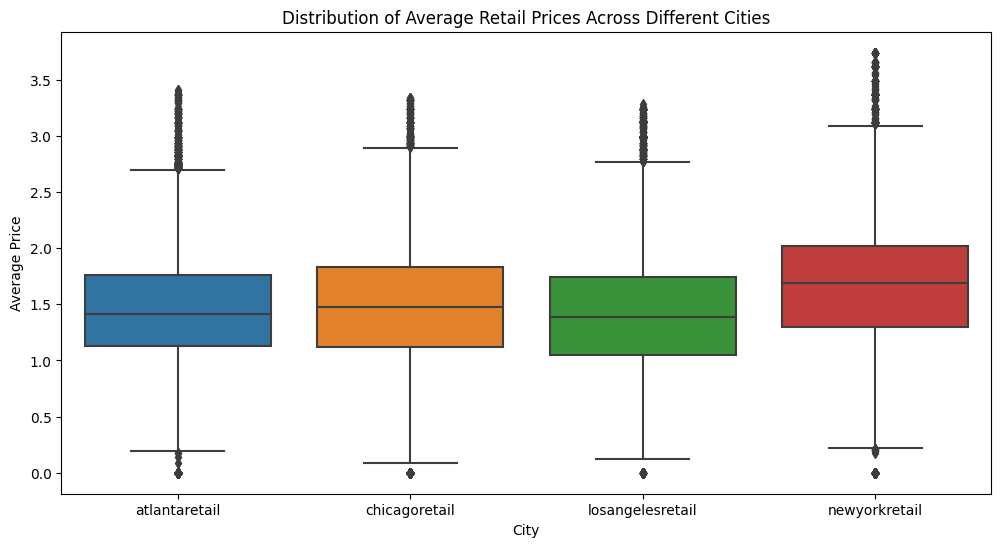

Text(0, 0.5, 'Percentage')

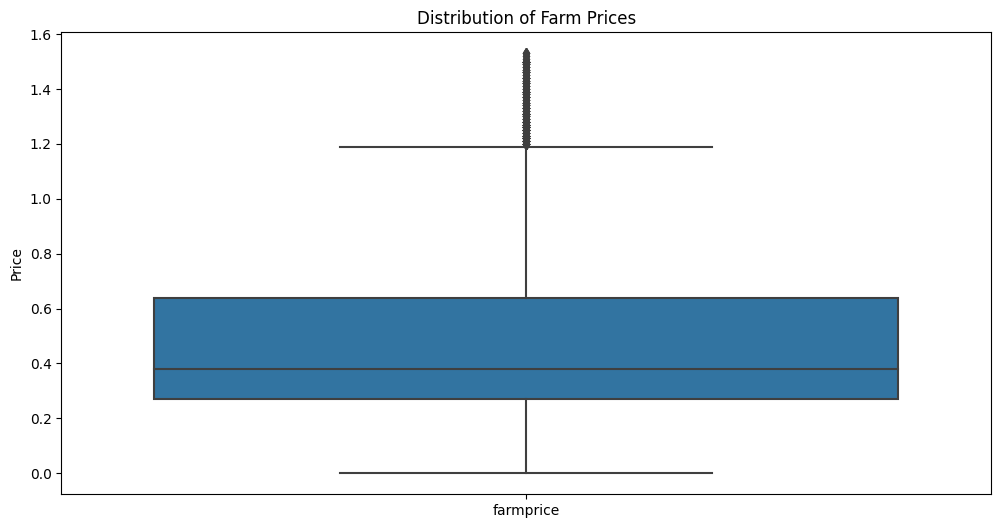

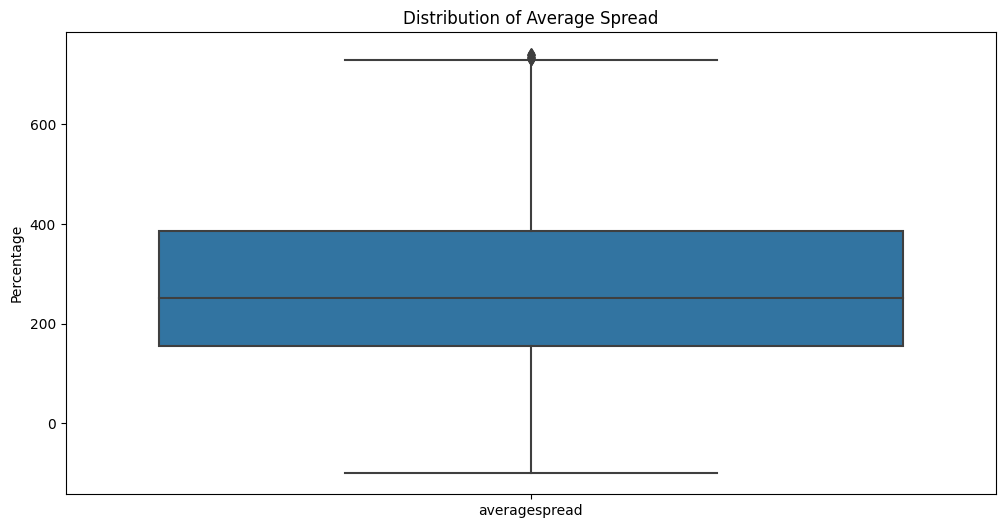

In [ ]:
#See distributions of different attributes
#Retail prices in different cities
cities = ['atlantaretail', 'chicagoretail', 'losangelesretail', 'newyorkretail']
plt.figure(figsize=(12, 6))
sns.boxplot(data=data[cities])
plt.title('Distribution of Average Retail Prices Across Different Cities')
plt.xlabel('City')
plt.ylabel('Average Price')
plt.show()

#Farm Price
farm_price = ['farmprice']
plt.figure(figsize=(12,6))
sns.boxplot(data=data[farm_price])
plt.title("Distribution of Farm Prices")
plt.ylabel('Price')

#Average Spread
average_spread = ['averagespread']
plt.figure(figsize=(12,6))
sns.boxplot(data=data[average_spread])
plt.title("Distribution of Average Spread")
plt.ylabel('Percentage')

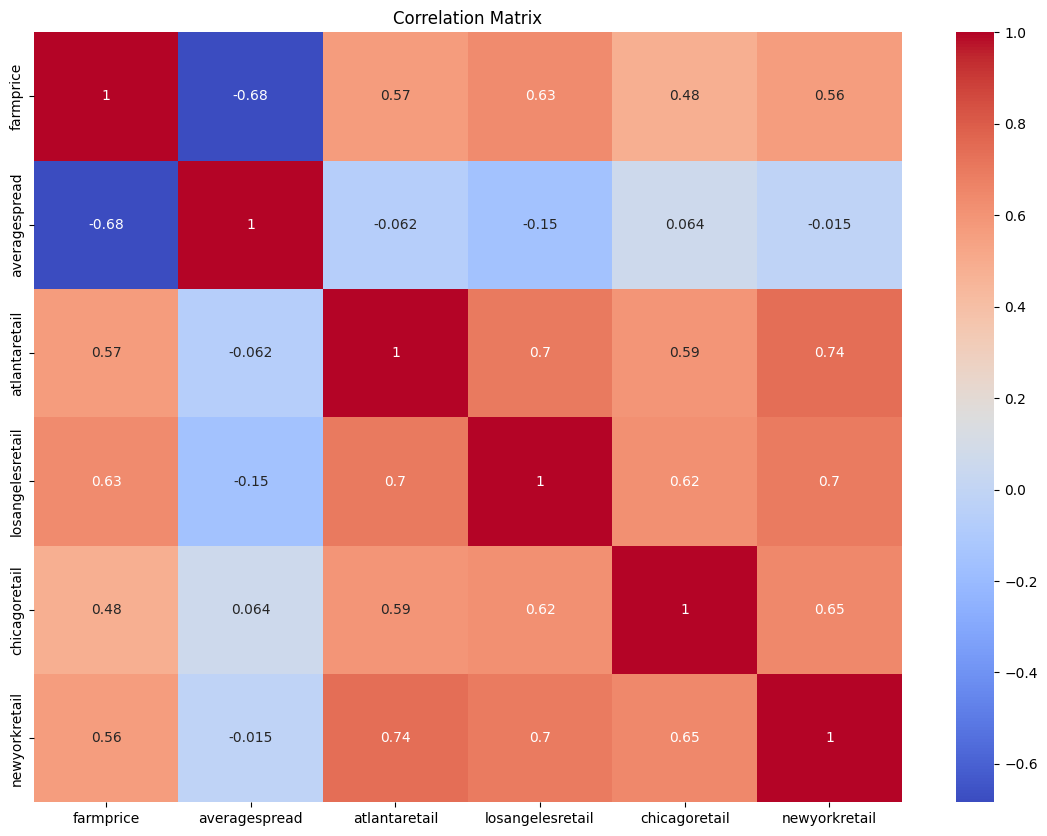

In [ ]:
#Correlation matrix to see relationships between variables
correlation_var = ['farmprice', 'averagespread', 'atlantaretail', 'losangelesretail', 'chicagoretail', 'newyorkretail']
selected_columns = data[correlation_var]
correlation_matrix = selected_columns.corr()
plt.figure(figsize=(14,10))
sns.heatmap(correlation_matrix, annot = True, cmap = 'coolwarm')
plt.title('Correlation Matrix')
plt.show()

3. **Feature Engineering**

In [ ]:
#Create dataframe for unique products in each year
data['date'] = pd.to_datetime(data['date'])
data['year'] = data['date'].dt.year
year_data = data.groupby(['year', 'productname']).agg({
    'atlantaretail': 'mean',
    'chicagoretail': 'mean',
    'losangelesretail': 'mean',
    'newyorkretail': 'mean',
    'farmprice': 'mean'
}).reset_index()

#Create a new column that finds average of all retail prices
year_data['average_retail_price'] = year_data[['atlantaretail', 'chicagoretail', 'losangelesretail', 'newyorkretail']].mean(axis=1)

year_data.head()

,year,productname,atlantaretail,chicagoretail,losangelesretail,newyorkretail,farmprice,average_retail_price
0,1999,Avocados,1.583333,0.0,1.976667,1.540000,1.010000,1.275000
1,1999,Broccoli Bunches,1.160000,0.0,0.978000,1.127000,0.342000,0.816250
2,1999,Broccoli Crowns,1.453000,0.0,1.150000,1.350000,0.458000,0.988250
3,1999,Cantaloupe,0.718750,0.0,0.637500,0.660000,0.256250,0.504062
4,1999,Carrots,0.651111,0.0,0.532222,0.615556,0.117778,0.449722


In [ ]:
#Create dataframe that combines all unique produce
#Add column for average retail prices in each city
produce_data = data.groupby('productname')[cities].mean()

#Add column for average spread of each unique product
individual_products = [
'Asparagus', 'Avocados', 'Broccoli Bunches', 'Broccoli Crowns', 'Cantaloupe', 'Carrots',
'Cauliflower', 'Celery', 'Flame Grapes', 'Green Leaf Lettuce', 'Honeydews', 'Iceberg Lettuce',
'Nectarines', 'Oranges', 'Peaches', 'Plums', 'Potatoes', 'Red Leaf Lettuce', 'Romaine Lettuce',
'Strawberries', 'Thompson Grapes', 'Tomatoes']
average_spreads = {}

#Loop to calculate the average spread for each product from all years
for product in individual_products:
    product_data = data[data['productname'] == product]
    average_spread = product_data['averagespread'].mean()
    average_spreads[product] = average_spread

#Dictionary of product names and corresponding average spread values from above
average_spreads = {
    'Asparagus': 126.59,
    'Avocados': 96.58,
    'Broccoli Bunches': 268.82,
    'Broccoli Crowns': 256.45,
    'Cantaloupe': 278.62,
    'Carrots': 245.87,
    'Cauliflower': 292.37,
    'Celery': 293.02,
    'Flame Grapes': 141.72,
    'Green Leaf Lettuce': 407.97,
    'Honeydews': 326.21,
    'Iceberg Lettuce': 291.64,
    'Nectarines': 269.87,
    'Oranges': 262.87,
    'Peaches': 291.72,
    'Plums': 209.95,
    'Potatoes': 257.12,
    'Red Leaf Lettuce': 436.81,
    'Romaine Lettuce': 392.44,
    'Strawberries': 149.24,
    'Thompson Grapes': 155.98,
    'Tomatoes': 290.35
}

#Add average spread column
produce_data['average_spread'] = produce_data.index.map(average_spreads)

#Categorize products based on the seasons in which they are produced
spring_produce = ['Asparagus','Avocados','Broccoli Bunches','Broccoli Crowns','Green Leaf Lettuce','Iceberg Lettuce','Red Leaf Lettuce','Romaine Lettuce','Strawberries']
summer_produce = ['Cantaloupe','Flame Grapes','Honeydews','Nectarines','Peaches','Plums','Thompson Grapes','Tomatoes']
fallwinter_produce = ['Carrots','Cauliflower','Celery','Potatoes','Oranges']

#Create loop for each season
product_seasons = {product: season for season, produce_list in
                   zip(['Fall/Winter', 'Spring', 'Summer'], [fallwinter_produce, spring_produce, summer_produce])
                   for product in produce_list}

#Add column for the season they are produced
produce_data['Season'] = produce_data.index.map(product_seasons)

produce_data.head()

,atlantaretail,chicagoretail,losangelesretail,newyorkretail,average_spread,Season
productname,,,,,,
Asparagus,2.550833,2.130833,2.411833,2.303917,126.59,Spring
Avocados,1.181317,1.379320,1.439660,1.599972,96.58,Spring
Broccoli Bunches,1.789990,1.416290,1.336363,1.730124,268.82,Spring
Broccoli Crowns,1.751359,1.568234,1.673085,1.745962,256.45,Spring
Cantaloupe,1.455863,1.465154,1.378534,1.582293,278.62,Summer


In [ ]:
#Create DataFrame that separates produce by season
#Grouping by season and calculating average for each city
seasonal_data = produce_data.groupby('Season').agg({
    'newyorkretail': 'mean',
    'losangelesretail': 'mean',
    'chicagoretail': 'mean',
    'atlantaretail': 'mean',
    'average_spread': 'mean'
}).reset_index()\

#Format
#Retail prices
def format_currency(value):
    return '{:.2f}'.format(value)
retail_columns = ['newyorkretail', 'losangelesretail', 'chicagoretail', 'atlantaretail']
seasonal_data[retail_columns] = seasonal_data[retail_columns].applymap(format_currency)
#Spread percentages
def format_percentage(value):
    return '{:.2f}'.format(value/100)
seasonal_data['average_spread'] = seasonal_data['average_spread'].apply(format_percentage)

seasonal_data = pd.DataFrame(seasonal_data)
seasonal_data.head()

,Season,newyorkretail,losangelesretail,chicagoretail,atlantaretail,average_spread
0,Fall/Winter,1.69,1.40,1.05,1.51,2.70
1,Spring,1.93,1.62,1.65,1.71,2.70
2,Summer,1.72,1.71,1.59,1.55,2.46


4. **Data Visualization**

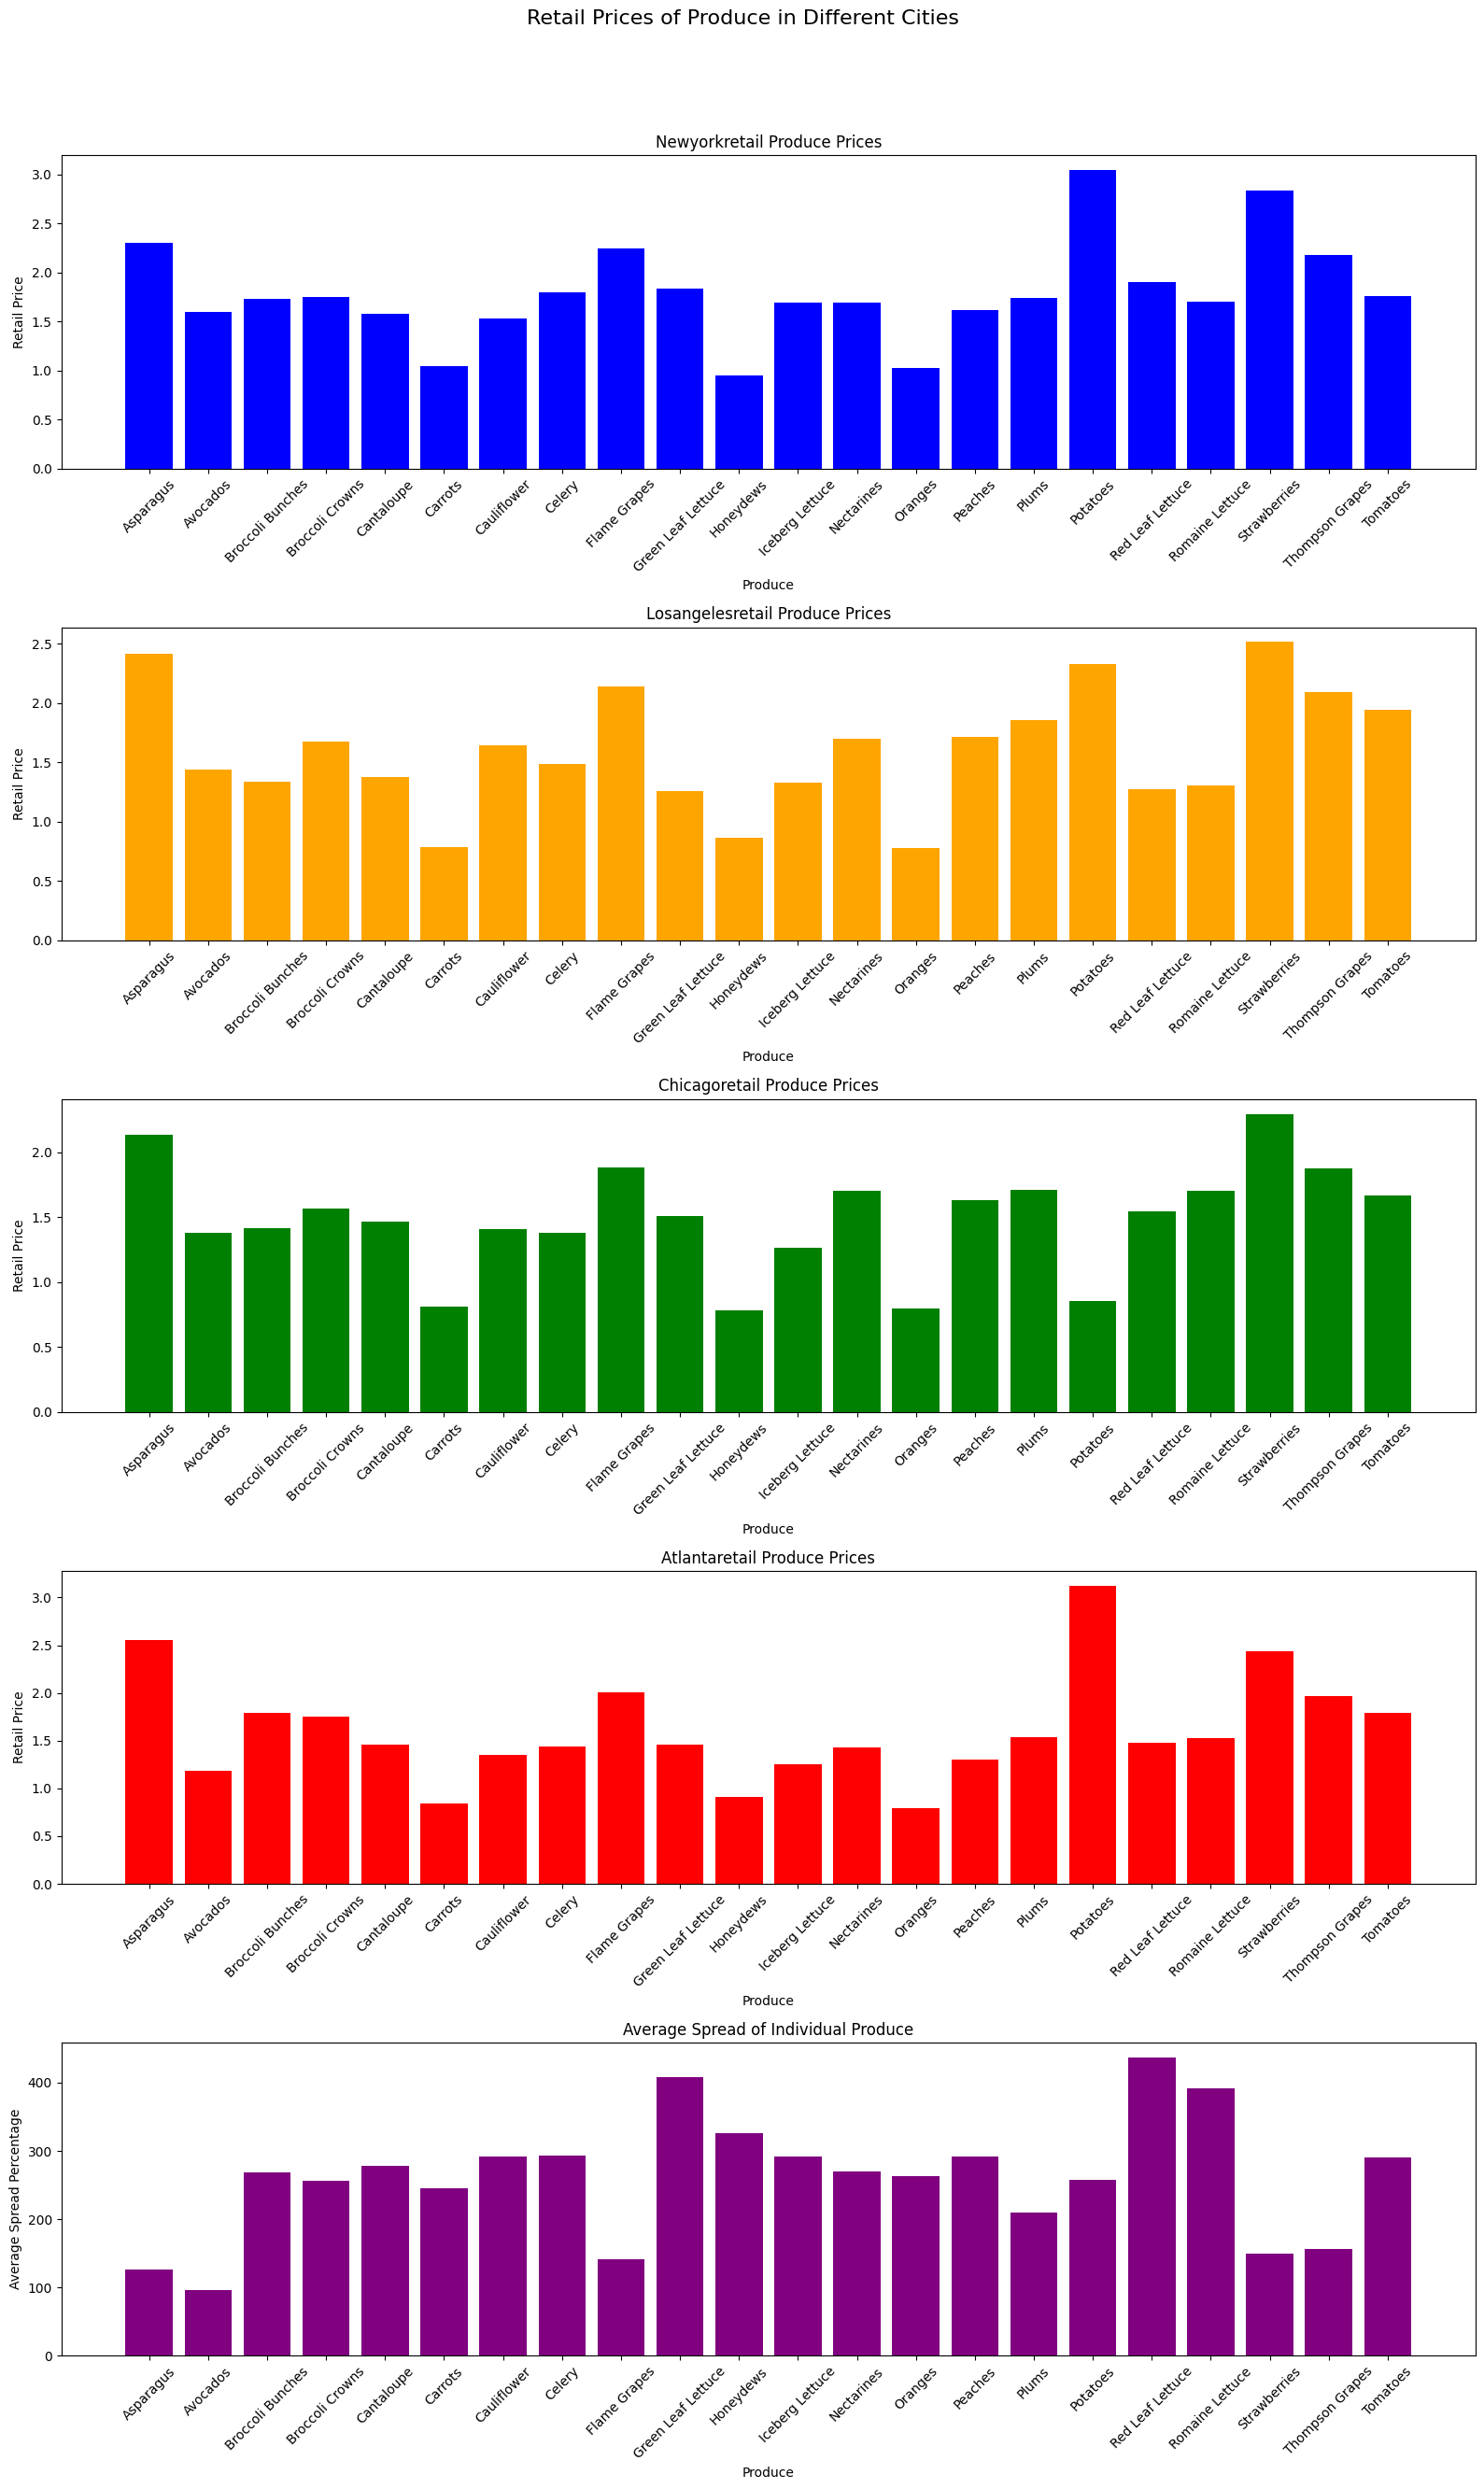

In [ ]:
#Visualize produce retail prices across all four cities
produce_data_reset = produce_data.reset_index()

#Set up subplots
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(16, 28))
fig.suptitle('Retail Prices of Produce in Different Cities', fontsize=16)
axes = axes.flatten()
cities = ['newyorkretail', 'losangelesretail', 'chicagoretail', 'atlantaretail']
custom_colors = ['blue', 'orange', 'green', 'red']

#Loop through each city
for i, city in enumerate(cities):
    for idx, (product, data) in enumerate(produce_data_reset.iterrows()):
        axes[i].bar(idx, data[city], color=custom_colors[i], label=product)
    axes[i].set_title(f'{city.capitalize()} Produce Prices')
    axes[i].set_xlabel('Produce')
    axes[i].set_ylabel('Retail Price')
    axes[i].set_xticks(range(len(produce_data_reset)))
    axes[i].set_xticklabels(produce_data_reset['productname'], rotation=45)

#Add average spread
axes[4].bar(produce_data_reset['productname'], produce_data_reset['average_spread'], color='purple')
axes[4].set_title('Average Spread of Individual Produce')
axes[4].set_xlabel('Produce')
axes[4].set_ylabel('Average Spread Percentage')
axes[4].tick_params(axis='x', rotation=45)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

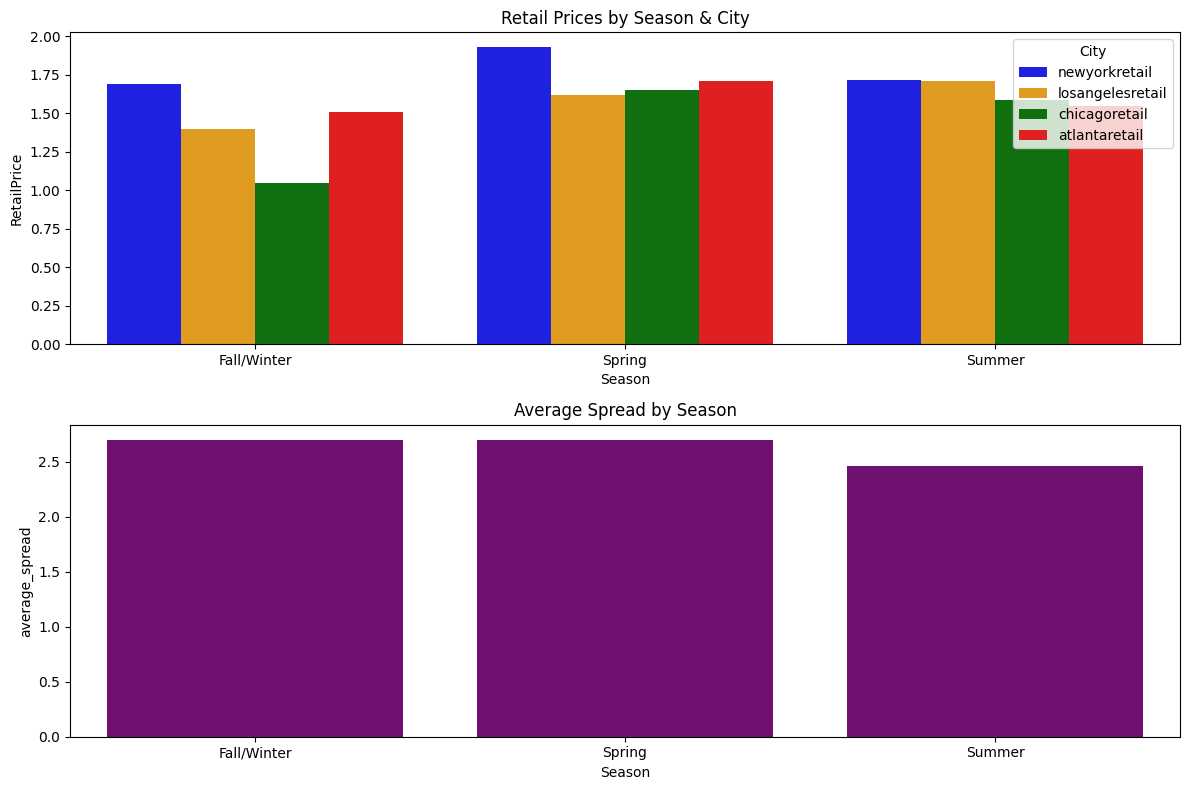

In [ ]:
#Visualize seasonal impact on price
#Average retail prices by season
city_columns = ['Season', 'newyorkretail', 'losangelesretail', 'chicagoretail', 'atlantaretail']
final_data_city = seasonal_data[city_columns]
final_data_city_long = final_data_city.melt(id_vars='Season', var_name='City', value_name='RetailPrice')
final_data_city_long['RetailPrice'] = pd.to_numeric(final_data_city_long['RetailPrice'], errors='coerce')
custom_palette = {'newyorkretail': 'blue', 'losangelesretail': 'orange', 'chicagoretail': 'green', 'atlantaretail': 'red'}

#Average spread by season
average_spread_data = seasonal_data[['Season', 'average_spread']].copy()
average_spread_data['average_spread'] = pd.to_numeric(average_spread_data['average_spread'], errors='coerce')

#Create subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))
sns.barplot(x='Season', y='RetailPrice', hue='City', data=final_data_city_long, palette=custom_palette, dodge=True, ax=axes[0])
axes[0].set_title('Retail Prices by Season & City')
sns.barplot(x='Season', y='average_spread', data=average_spread_data, color='purple', ax=axes[1])
axes[1].set_title('Average Spread by Season')

plt.tight_layout()
plt.show()

In [ ]:
#Build interactive dashboard for historical analysis
unique_produce_names = year_data['productname'].unique()

#Initialize the Dash app
app = dash.Dash(__name__)
#Design layout
app.layout = html.Div([
    html.H1("Historical Prices Dashboard"),
    dcc.Dropdown(
        id='produce-dropdown',
        options=[{'label': produce, 'value': produce} for produce in unique_produce_names],
        value=unique_produce_names[0],
        multi=False
    ),
    dcc.Graph(id='price-graph')
])
#Callback for interactivity
@app.callback(
    Output('price-graph', 'figure'),
    [Input('produce-dropdown', 'value')]
)
def update_graph(selected_produce):
    selected_data = year_data[year_data['productname'] == selected_produce]
    fig = px.line(selected_data, x='year', y=['farmprice', 'average_retail_price'],
                  labels={'value': 'Price', 'year': 'Year'},
                  title=f'Historical Prices for {selected_produce}')
    return fig
#Run app
if __name__ == '__main__':
    app.run_server(debug=True, mode = 'inline')

<IPython.core.display.Javascript object>